# Ajuste y preparación de datos

preprocesamiento y preparación de los datos para el modelado de machine learning.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cargar los datos del EDA

ruta_datos = Path.cwd() / "datos"
ruta_archivo = ruta_datos / "02_datos_exploratorios_medical_noshow.csv"

datos = pd.read_csv(ruta_archivo)

print(f"Dimensiones del dataset: {datos.shape}")
print(f"\nPrimeras filas:")
datos.head()

Dimensiones del dataset: (71959, 18)

Primeras filas:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age_Group,DayOfWeek,Days_Advance,No_show_numeric
0,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,65+,Friday,1,0
1,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,19-30,Friday,1,1
2,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,31-50,Friday,1,1
3,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,19-30,Friday,1,0
4,7.345362e+14,5630213,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,19-30,Friday,1,0


In [4]:
# Verificar información del dataset

print("\nValores nulos:")
print(datos.isnull().sum())

print("\nDistribución de la variable objetivo:")
print(datos['No-show'].value_counts(normalize=True))


Valores nulos:
PatientId             0
AppointmentID         0
Gender                0
ScheduledDay          0
AppointmentDay        0
Age                   0
Neighbourhood         0
Scholarship           0
Hipertension          0
Diabetes              0
Alcoholism            0
Handcap               0
SMS_received          0
No-show               0
Age_Group          2136
DayOfWeek             0
Days_Advance          0
No_show_numeric       0
dtype: int64

Distribución de la variable objetivo:
No-show
No     0.71481
Yes    0.28519
Name: proportion, dtype: float64


## Selección de variables para el modelo



In [5]:

variables_a_excluir = [
    'PatientId',           
    'AppointmentID',
    'ScheduledDay',
    'AppointmentDay',
    'No-show',
    'Neighbourhood'
]


datos_modelo = datos.drop(columns=variables_a_excluir)

print(f"Variables seleccionadas para el modelo:")
for col in datos_modelo.columns:
    print(f"- {col}")
    
print(f"\nNueva dimensión: {datos_modelo.shape}")

Variables seleccionadas para el modelo:
- Gender
- Age
- Scholarship
- Hipertension
- Diabetes
- Alcoholism
- Handcap
- SMS_received
- Age_Group
- DayOfWeek
- Days_Advance
- No_show_numeric

Nueva dimensión: (71959, 12)


In [6]:



target = 'No_show_numeric'
variables_numericas = ['Age', 'Days_Advance']

# Variables binarias (ya codificadas como 0/1)
variables_binarias = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']

variables_categoricas = ['Gender', 'Age_Group', 'DayOfWeek']

variables_ordinales = ['Handcap']



## Tratamiento de variables categóricas

In [7]:
#categorías únicas de variables categóricas

for var in variables_categoricas:
    print(f"\n{var}:")
    print(datos_modelo[var].value_counts())


Gender:
Gender
F    48070
M    23889
Name: count, dtype: int64

Age_Group:
Age_Group
31-50    19281
51-65    15327
0-18     14904
19-30    10930
65+       9381
Name: count, dtype: int64

DayOfWeek:
DayOfWeek
Wednesday    17044
Tuesday      16462
Monday       14581
Friday       12516
Thursday     11325
Saturday        31
Name: count, dtype: int64


In [8]:
# Codificación de variables categóricas

datos_procesados = datos_modelo.copy()

# 1. Gender: Label Encoding 
le_gender = LabelEncoder()
datos_procesados['Gender_encoded'] = le_gender.fit_transform(datos_procesados['Gender'])

# 2. Age_Group: Mantener orden 
age_group_mapping = {
    '0-18': 0,
    '19-30': 1, 
    '31-50': 2,
    '51-65': 3,
    '65+': 4
}
datos_procesados['Age_Group_encoded'] = datos_procesados['Age_Group'].map(age_group_mapping)

# 3. DayOfWeek: One-Hot Encoding
day_dummies = pd.get_dummies(datos_procesados['DayOfWeek'], prefix='Day')
datos_procesados = pd.concat([datos_procesados, day_dummies], axis=1)


print(f"Nuevas columnas creadas: {list(day_dummies.columns)}")
print(f"Dimensión actual: {datos_procesados.shape}")

Nuevas columnas creadas: ['Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
Dimensión actual: (71959, 20)


In [9]:
# Eliminar variables categóricas originales
datos_procesados = datos_procesados.drop(columns=['Gender', 'Age_Group', 'DayOfWeek'])

print("Variables finales para el modelo:")
for col in sorted(datos_procesados.columns):
    if col != target:
        print(f"- {col}")

print(f"\nDimensión final: {datos_procesados.shape}")

Variables finales para el modelo:
- Age
- Age_Group_encoded
- Alcoholism
- Day_Friday
- Day_Monday
- Day_Saturday
- Day_Thursday
- Day_Tuesday
- Day_Wednesday
- Days_Advance
- Diabetes
- Gender_encoded
- Handcap
- Hipertension
- SMS_received
- Scholarship

Dimensión final: (71959, 17)


## Análisis de correlación

Correlaciones con No_show_numeric ordenadas por magnitud:
  Age_Group_encoded: -0.108
  Age: -0.101
  Days_Advance: 0.060
  Hipertension: -0.057
  Scholarship: 0.046
  Diabetes: -0.022
  SMS_received: -0.021
  Alcoholism: 0.020
  Day_Monday: 0.019
  Day_Wednesday: -0.017
  Day_Thursday: -0.012
  Day_Friday: 0.008
  Handcap: -0.007
  Gender_encoded: 0.002
  Day_Tuesday: 0.002
  Day_Saturday: 0.000


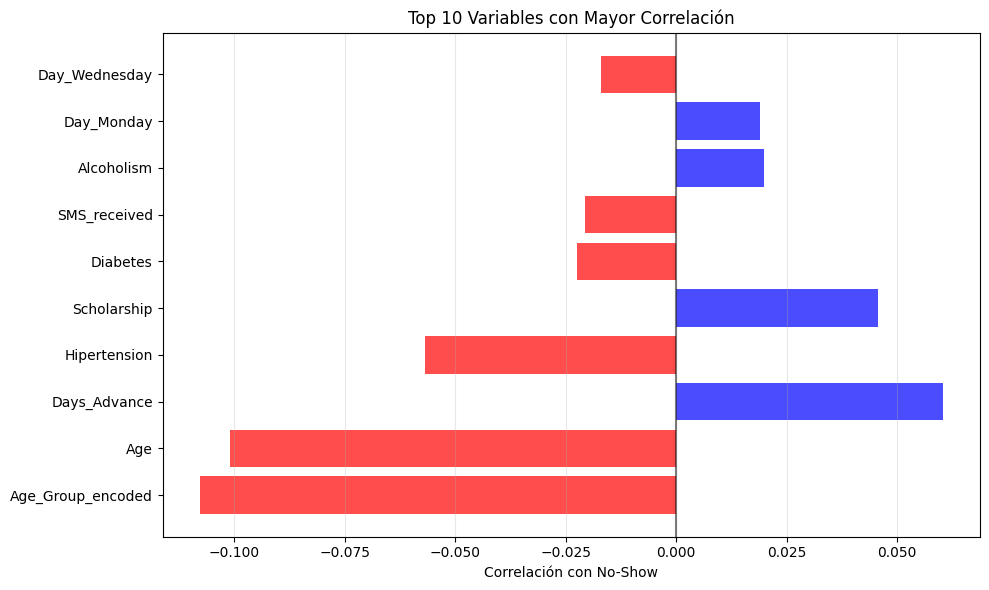

In [10]:
# Matriz de correlación de variables 

# solo variables numéricas para correlación
variables_numericas_finales = [col for col in datos_procesados.columns if col != target]
correlaciones = datos_procesados[variables_numericas_finales + [target]].corr()

# Correlaciones con variable objetivo
corr_target = correlaciones[target].drop(target).sort_values(key=abs, ascending=False)

print("Correlaciones con No_show_numeric ordenadas por magnitud:")
for var, corr in corr_target.items():
    print(f"  {var}: {corr:.3f}")

# Visualizar top correlaciones
plt.figure(figsize=(10, 6))
top_corr = corr_target.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlación con No-Show')
plt.title('Top 10 Variables con Mayor Correlación')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

## División de datos

In [11]:
# Separar características (X) y variable objetivo (y)
X = datos_procesados.drop(columns=[target])
y = datos_procesados[target]

print(f"Características (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")
print(f"\nDistribución de y:")
print(y.value_counts(normalize=True))

Características (X): (71959, 16)
Variable objetivo (y): (71959,)

Distribución de y:
No_show_numeric
0    0.71481
1    0.28519
Name: proportion, dtype: float64


In [12]:
# División estratificada train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mantener proporción de clases
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts(normalize=True))

print(f"\nDistribución en prueba:")
print(y_test.value_counts(normalize=True))

Conjunto de entrenamiento: (57567, 16)
Conjunto de prueba: (14392, 16)

Distribución en entrenamiento:
No_show_numeric
0    0.714802
1    0.285198
Name: proportion, dtype: float64

Distribución en prueba:
No_show_numeric
0    0.714842
1    0.285158
Name: proportion, dtype: float64


## Escalado de variables numéricas

In [13]:

variables_para_escalar = ['Age', 'Days_Advance']

print("Estadísticas antes del escalado:")
print(X_train[variables_para_escalar].describe())

# StandardScaler solo a variables numéricas continuas
scaler = StandardScaler()

# Crear copias 
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Escalar variables seleccionadas
X_train_scaled[variables_para_escalar] = scaler.fit_transform(X_train[variables_para_escalar])
X_test_scaled[variables_para_escalar] = scaler.transform(X_test[variables_para_escalar])

print("\nEstadísticas después del escalado:")
print(X_train_scaled[variables_para_escalar].describe())

Estadísticas antes del escalado:
                Age  Days_Advance
count  57567.000000  57567.000000
mean      38.539997     14.623778
std       22.898009     16.509457
min        0.000000      0.000000
25%       20.000000      3.000000
50%       39.000000      8.000000
75%       57.000000     21.000000
max      115.000000    178.000000

Estadísticas después del escalado:
                Age  Days_Advance
count  5.756700e+04  5.756700e+04
mean   4.838410e-17 -5.430868e-18
std    1.000009e+00  1.000009e+00
min   -1.683130e+00 -8.857896e-01
25%   -8.096843e-01 -7.040739e-01
50%    2.008939e-02 -4.012146e-01
75%    8.061908e-01  3.862197e-01
max    3.339184e+00  9.896003e+00


## Análisis de los datos preparados

In [14]:

print(f"\nDimensiones finales:")
print(f"  - Entrenamiento: {X_train_scaled.shape}")
print(f"  - Prueba: {X_test_scaled.shape}")

print(f"\nVariables finales ({len(X_train_scaled.columns)}):")
for i, col in enumerate(sorted(X_train_scaled.columns), 1):
    print(f"  {i:2d}. {col}")

print(f"\nBalance de clases:")
print(f"  - No-Show: {(y_train == 1).mean():.1%}")
print(f"  - Show: {(y_train == 0).mean():.1%}")

print(f"\nTipos de datos:")
print(X_train_scaled.dtypes.value_counts())


Dimensiones finales:
  - Entrenamiento: (57567, 16)
  - Prueba: (14392, 16)

Variables finales (16):
   1. Age
   2. Age_Group_encoded
   3. Alcoholism
   4. Day_Friday
   5. Day_Monday
   6. Day_Saturday
   7. Day_Thursday
   8. Day_Tuesday
   9. Day_Wednesday
  10. Days_Advance
  11. Diabetes
  12. Gender_encoded
  13. Handcap
  14. Hipertension
  15. SMS_received
  16. Scholarship

Balance de clases:
  - No-Show: 28.5%
  - Show: 71.5%

Tipos de datos:
int64      7
bool       6
float64    3
Name: count, dtype: int64


In [15]:

print("Verificación de valores nulos:")
print(f"X_train: {X_train_scaled.isnull().sum().sum()}")
print(f"X_test: {X_test_scaled.isnull().sum().sum()}")
print(f"y_train: {y_train.isnull().sum()}")
print(f"y_test: {y_test.isnull().sum()}")

print("\nRangos de variables escaladas:")
for var in variables_para_escalar:
    min_val = X_train_scaled[var].min()
    max_val = X_train_scaled[var].max()
    print(f"  {var}: [{min_val:.2f}, {max_val:.2f}]")

Verificación de valores nulos:
X_train: 1691
X_test: 445
y_train: 0
y_test: 0

Rangos de variables escaladas:
  Age: [-1.68, 3.34]
  Days_Advance: [-0.89, 9.90]


## Guardar Datos Preparados

In [16]:


import pickle

ruta_datos_procesados = Path.cwd() / "data"
ruta_modelos = Path.cwd() / "models"

ruta_datos_procesados.mkdir(parents=True, exist_ok=True)
ruta_modelos.mkdir(parents=True, exist_ok=True)

# Guardar conjuntos de datos
X_train_scaled.to_csv(ruta_datos_procesados / "X_train.csv", index=False)
X_test_scaled.to_csv(ruta_datos_procesados / "X_test.csv", index=False)
y_train.to_csv(ruta_datos_procesados / "y_train.csv", index=False)
y_test.to_csv(ruta_datos_procesados / "y_test.csv", index=False)

# Guardar objetos de transformación
with open(ruta_modelos / "scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

with open(ruta_modelos / "label_encoder_gender.pkl", 'wb') as f:
    pickle.dump(le_gender, f)

# Guardar mapeos
mappings = {
    'age_group_mapping': age_group_mapping,
    'variables_para_escalar': variables_para_escalar,
    'variables_finales': list(X_train_scaled.columns)
}

with open(ruta_modelos / "mappings.pkl", 'wb') as f:
    pickle.dump(mappings, f)

